In [125]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from copy import deepcopy

import math

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.random import sample_without_replacement

----

In [2]:
def rgb2gray(img):
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140]).astype('uint8')

In [3]:
PATH = "img/"

----

In [11]:
'''
    Total Least Squares method (slide 08/70)
    ^ idea - distance between (x_i, y_i) and line (ax_i + by_i = d) with (a^2 + b^2 = 1)
             is |ax_i + by_i - d|
             
    - minimize the sum of squares
    
    @param X - (N,) array
    @param Y - (N,) array
'''
class TotalLeastSquares:
    def fit(self, X, y):
        X_mean = np.mean(X)
        y_mean = np.mean(y)
        
        # np.column_stack()
        U = np.stack([X - X_mean, y - y_mean], axis=-1)
        
        eigenvalues, eigenvectors = np.linalg.eig(U.T @ U)
        
        # select the eigenvector corresponding to the smallest eigenvalue
        pos = np.argmin(eigenvalues)
        a, b = eigenvectors[:, pos]
        
        d = a * X_mean + b * y_mean
        if (b == 0):
            # vertical line
            # add a small value to be able to convert to
            # (y = mx + n)
            b = 1e-4
        
        return (a, b, d)

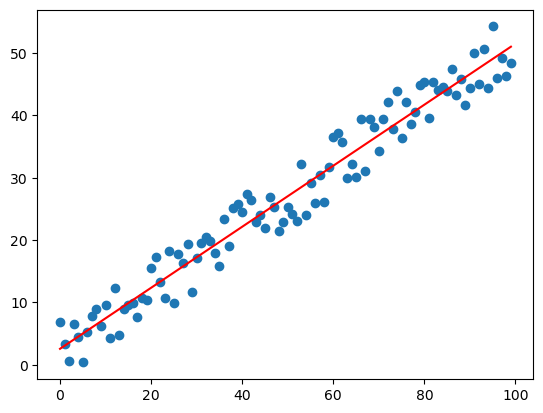

In [13]:
noise = np.random.uniform(-5, 5, 100)

xs = np.arange(100)
ys = .5 * xs + 2 + noise
plt.scatter(xs, ys)

tls = TotalLeastSquares()
a, b, d = tls.fit(xs, ys)

m, n = (-a/b), (d/b)
pred = [(m * x + n) for x in xs]

plt.plot(xs, pred, color='red')

----

## RANSAC

In [71]:
class RANSAC:
    def __init__(self, n_iters=2000, n_samples=2, dist_to_line=4, dist_points=4):
        self.n_iters = n_iters
        
        self.n_samples = n_samples
        
        self.dist_to_line = dist_to_line
        self.dist_points = dist_points
    
    '''
        Find the best _segment_ from the set of _inlier_ points
    '''
    def get_best_segment(self, X, y):
        xmax = np.max(X)
        xmin = np.min(X)
        
        if (xmax - xmin < 4):
            idxs = np.argsort(y)
        else:
            idxs = np.argsort(X)
        
        Xs = X[idxs]
        ys = y[idxs]
        
        N = Xs.shape[0]
        
        max_count = 0
        pos = -1
        
        count = 1
        for i in range(1, N):
            dx = (Xs[i] - Xs[i - 1]) ** 2
            dy = (ys[i] - ys[i - 1]) ** 2
            d = np.sqrt(dx + dy)
            
            if (d < self.dist_points):
                count += 1
            else:
                if (count > max_count):
                    max_count = count
                    pos = i
                
                count = 1
        
        if (count > max_count):
            max_count = count
            pos = N
        
        start = pos - max_count
        end = pos
        
        return Xs[start:end], ys[start:end], idxs[start:end]
    
    def fit(self, X, y):
        N = X.shape[0]
        
        tls = TotalLeastSquares()
        
        max_inliers = 0
        res = None
        for _ in range(self.n_iters):
            idxs = sample_without_replacement(N, self.n_samples)
            
            X_samples = X[idxs]
            y_samples = y[idxs]
            
            a, b, d = tls.fit(X_samples, y_samples)
            
            distances = np.abs(a * X + b * y - d)
            inliers = np.where(distances < self.dist_to_line)[0]
            
            X_inliers = X[inliers]
            y_inliers = y[inliers]
            
            X_segment, y_segment, idxs_segment = self.get_best_segment(X_inliers, y_inliers)
            idxs_segment = inliers[idxs_segment] # translate to the original set of points
            
            if (len(idxs_segment) > max_inliers):
                max_inliers = len(idxs_segment)
                
                # refit only on the new inliers
                a, b, d = tls.fit(X_segment, y_segment)
                res = ((a, b, d), idxs_segment, X_segment, y_segment)
        
        return res

93 inliers
(m, n) - (0.5123215269817057, 0.8505031343953704)


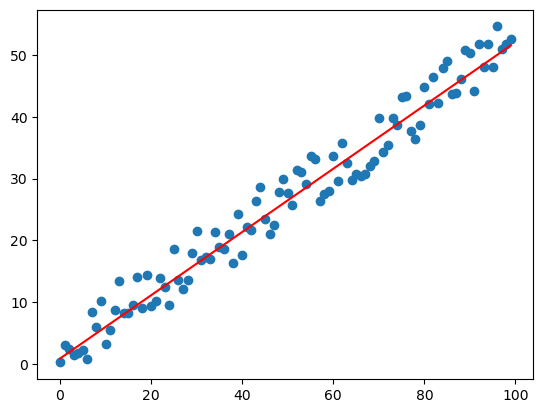

In [73]:
noise = np.random.uniform(-5, 5, 100)

xs = np.arange(100)
ys = .5 * xs + 2 + noise
plt.scatter(xs, ys)

model = RANSAC(dist_points=100)
(a, b, d), inliers, X_inliers, y_inliers = model.fit(xs, ys)

print(f"{len(inliers)} inliers")

m, n = (-a/b), (d/b)
pred = [(m * x + n) for x in X_inliers]

print(f"(m, n) - ({m}, {n})")

plt.plot(X_inliers, pred, color='red')

- multiple lines - init test 

23 inliers
(m, n) - (-0.3683676651571596, -1.7948620693363466)
21 inliers
(m, n) - (0.33767329996328516, 2.1243620413686553)


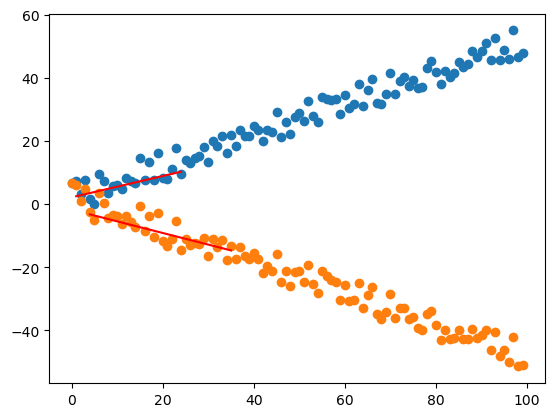

In [78]:
noise = np.random.uniform(-5, 5, 100)

xps = np.arange(100)
yps = .5 * xps + 2 + noise
plt.scatter(xps, yps)

xns = np.arange(100)
yns = -.5 * xns + 2 + noise
plt.scatter(xns, yns)

xs = np.concatenate([xps, xns], axis=0)
ys = np.concatenate([yps, yns], axis=0)

model = RANSAC()

## -- 1 --
(a, b, d), inliers, X_inliers, y_inliers = model.fit(xs, ys)

print(f"{len(inliers)} inliers")

m, n = (-a/b), (d/b)
pred = [(m * x + n) for x in X_inliers]

print(f"(m, n) - ({m}, {n})")

plt.plot(X_inliers, pred, color='red')

## --------------------

## -- 2 --
(a, b, d), inliers, X_inliers, y_inliers = model.fit(np.delete(xs, inliers), np.delete(ys, inliers))

print(f"{len(inliers)} inliers")

m, n = (-a/b), (d/b)
pred = [(m * x + n) for x in X_inliers]

print(f"(m, n) - ({m}, {n})")

plt.plot(X_inliers, pred, color='red')

## --------------------

----

In [120]:
def detect_lines(X, y, n_lines):
    model = RANSAC()
    
    Xc = deepcopy(X)
    yc = deepcopy(y)
    
    # each line - ((x0, y0), (x1, y1))
    lines = []
    for _ in range(n_lines):
        (a, b, d), inliers, X_inliers, y_inliers = model.fit(Xc, yc)
        
        xmin = np.min(X_inliers)
        xmax = np.max(X_inliers)
        if ((xmax - xmin) < 4.0):
            lines.append(((X_inliers[0], y_inliers[0]),\
                          (X_inliers[-1], y_inliers[-1])))
        else:
            m, n = (-a/b), (d/b)

            x0 = np.min(X_inliers)
            y0 = int(m * x0 + n) # need a pixel

            x1 = np.max(X_inliers)
            y1 = int(m * x1 + n)

            lines.append(((x0, y0), (x1, y1)))
        
        # remove the inliers for the next line
        Xc = np.delete(Xc, inliers)
        yc = np.delete(yc, inliers)
    
    return lines

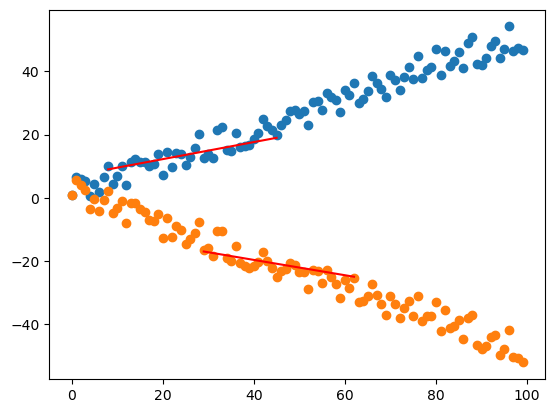

In [80]:
noise = np.random.uniform(-5, 5, 100)

xps = np.arange(100)
yps = .5 * xps + 2 + noise
plt.scatter(xps, yps)

xns = np.arange(100)
yns = -.5 * xns + 2 + noise
plt.scatter(xns, yns)

xs = np.concatenate([xps, xns], axis=0)
ys = np.concatenate([yps, yns], axis=0)

lines = detect_lines(xs, ys, 2)
for line in lines:
    (x0, y0), (x1, y1) = line
    plt.plot([x0, x1], [y0, y1], color='red')

----

(-0.5, 998.5, 490.5, -0.5)

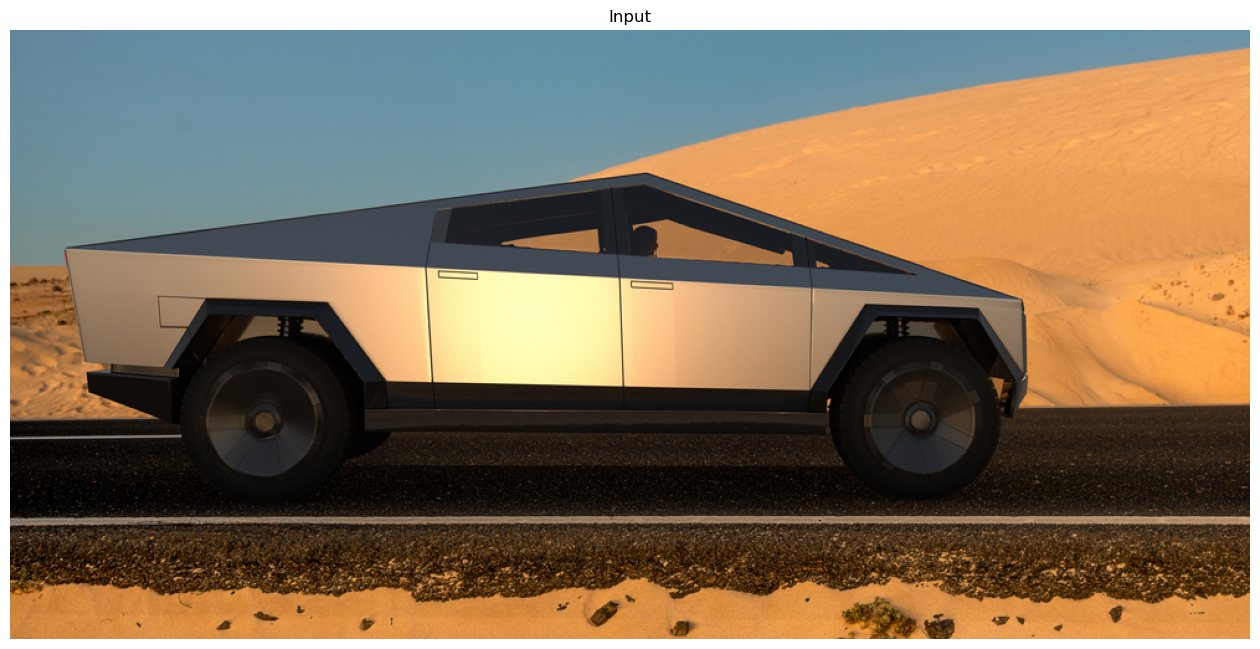

In [81]:
img = cv2.imread(PATH + "07.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Input')
ax1.imshow(img)
ax1.axis('off')

In [5]:
img.shape

(491, 999, 3)

(-0.5, 998.5, 490.5, -0.5)

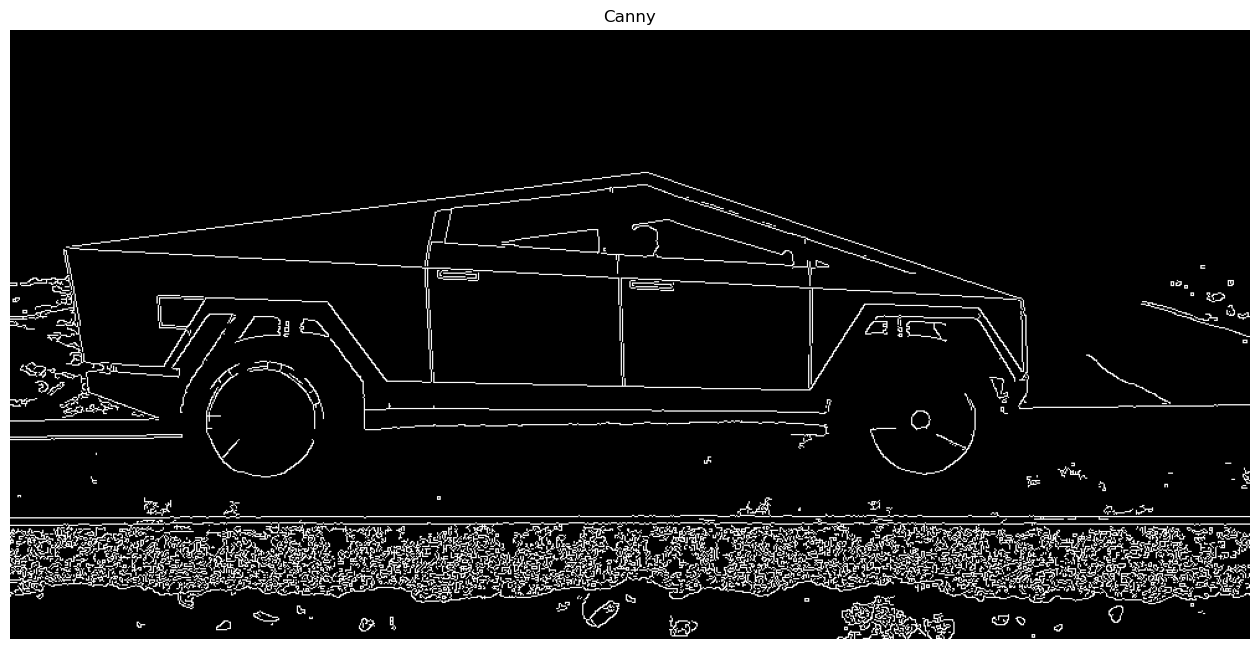

In [82]:
img_gray = img.copy()
img_gray = rgb2gray(img_gray)
img_gray = cv2.Canny(img_gray, threshold1=40, threshold2=250, apertureSize=3)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Canny')
ax1.imshow(img_gray, cmap='gray')
ax1.axis('off')

----

- translate into cartesian coordinates
  - y-axis only

In [83]:
y_white, X_white = np.where(img_gray == 255)
y_white = img.shape[0] - y_white # cartesian - flip the axis

y_white.shape, X_white.shape

((31739,), (31739,))

In [86]:
lines = detect_lines(X_white, y_white, 40)

(-0.5, 998.5, 490.5, -0.5)

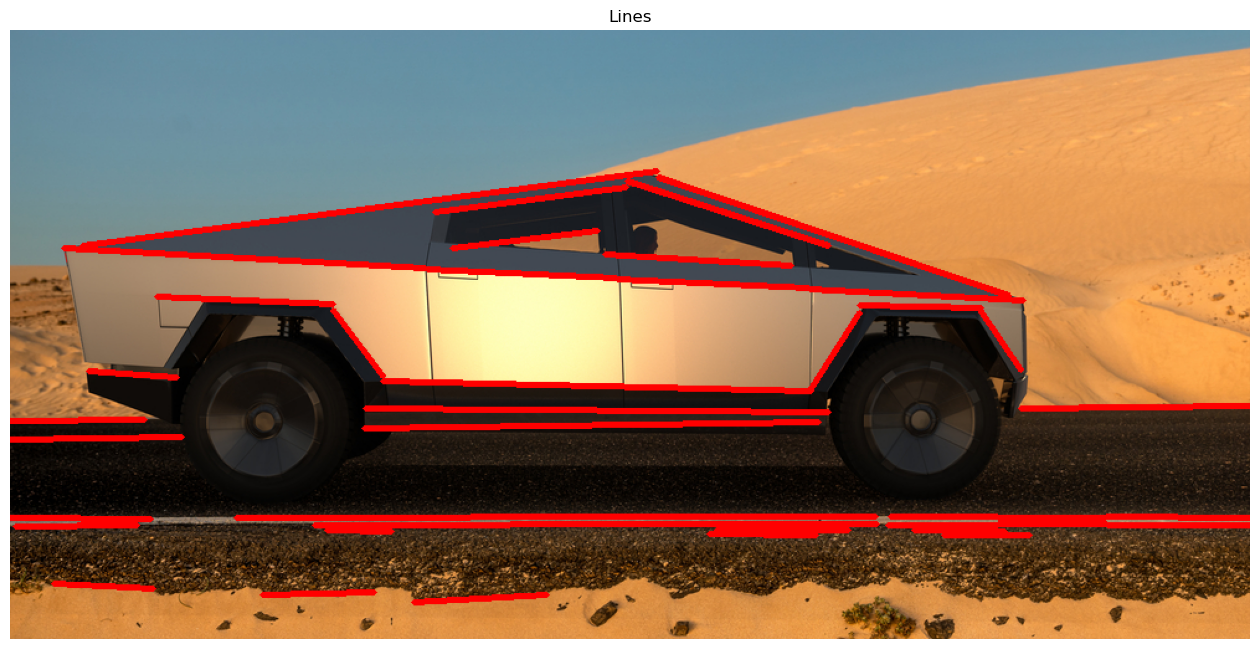

In [87]:
img_lines = deepcopy(img)

for line in lines:
    (x0, y0), (x1, y1) = line
    
    cv2.line(img_lines, (x0, img.shape[0] - y0),\
                        (x1, img.shape[0] - y1), (255, 0, 0), thickness=4)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Lines')
ax1.imshow(img_lines)
ax1.axis('off')

----

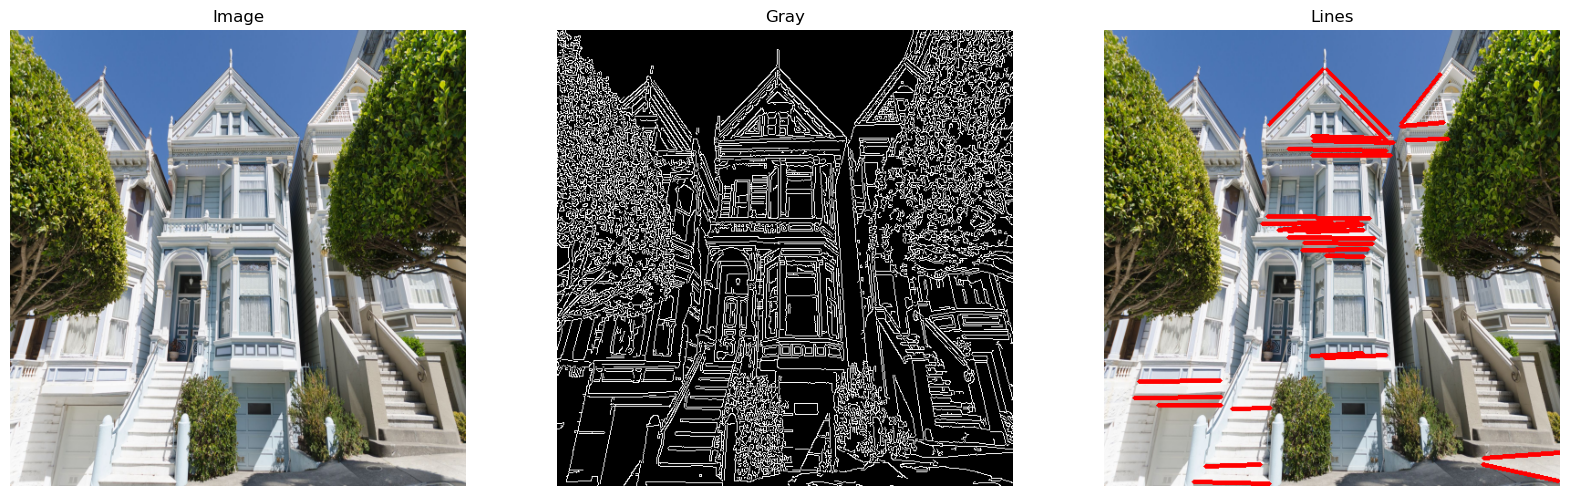

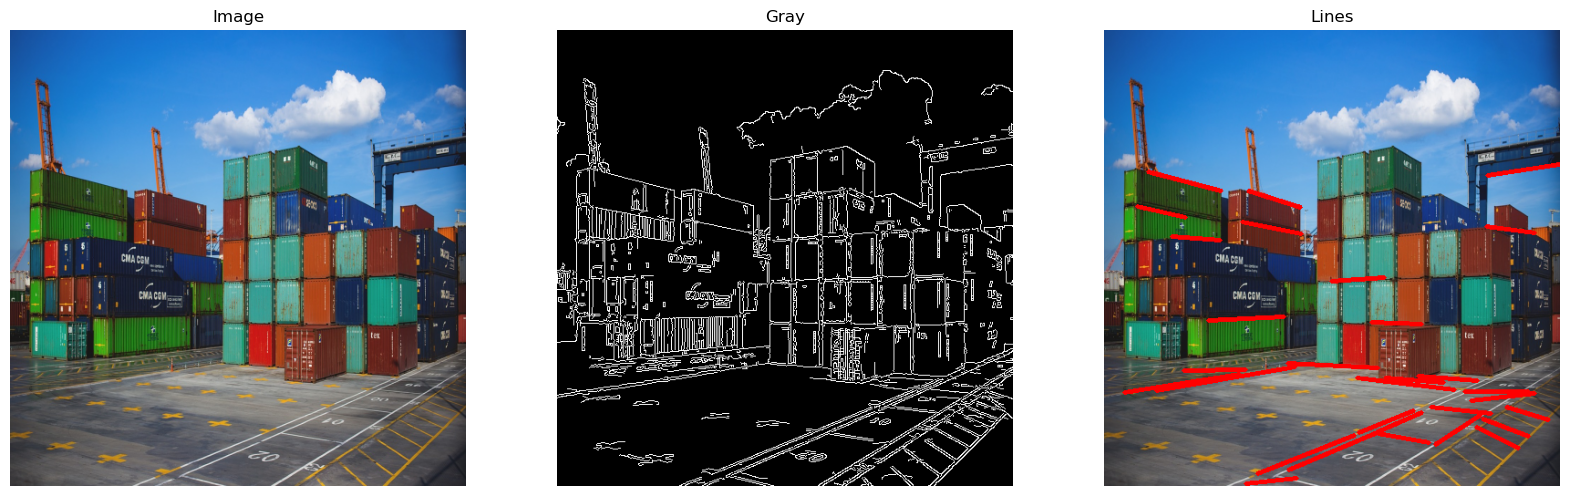

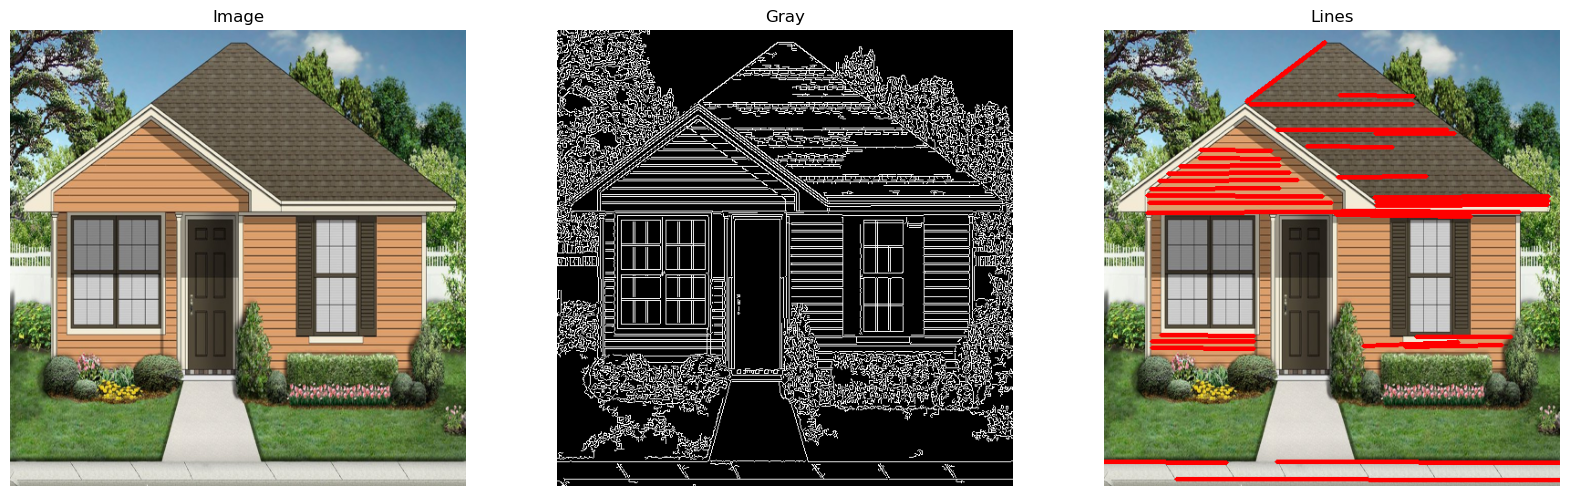

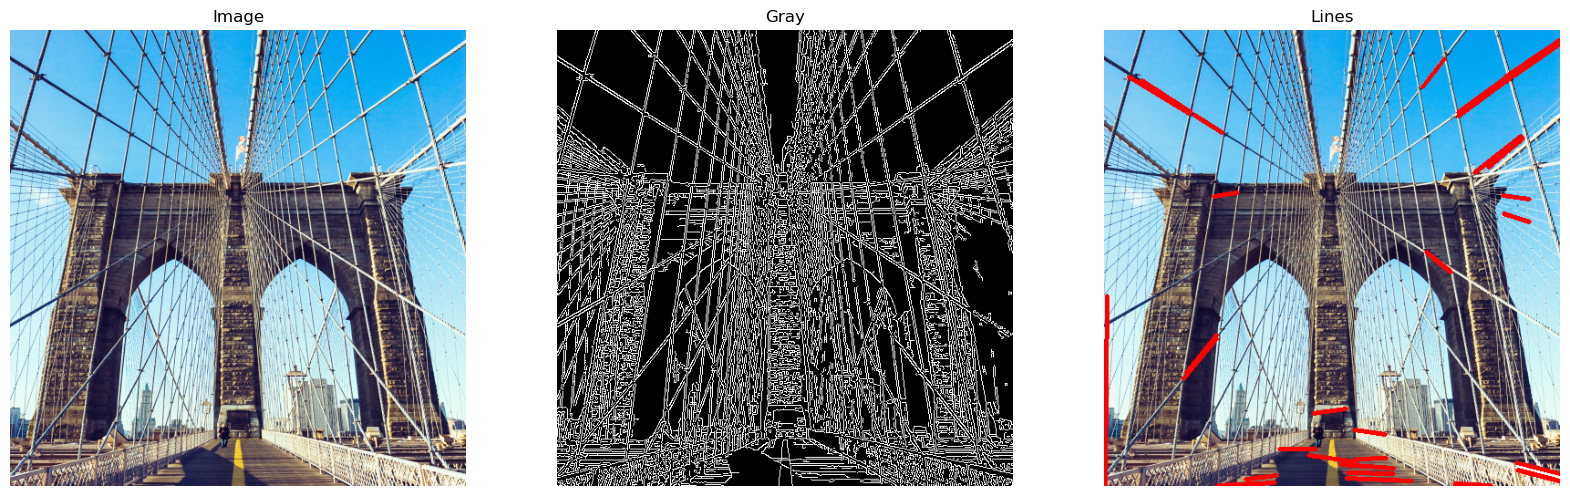

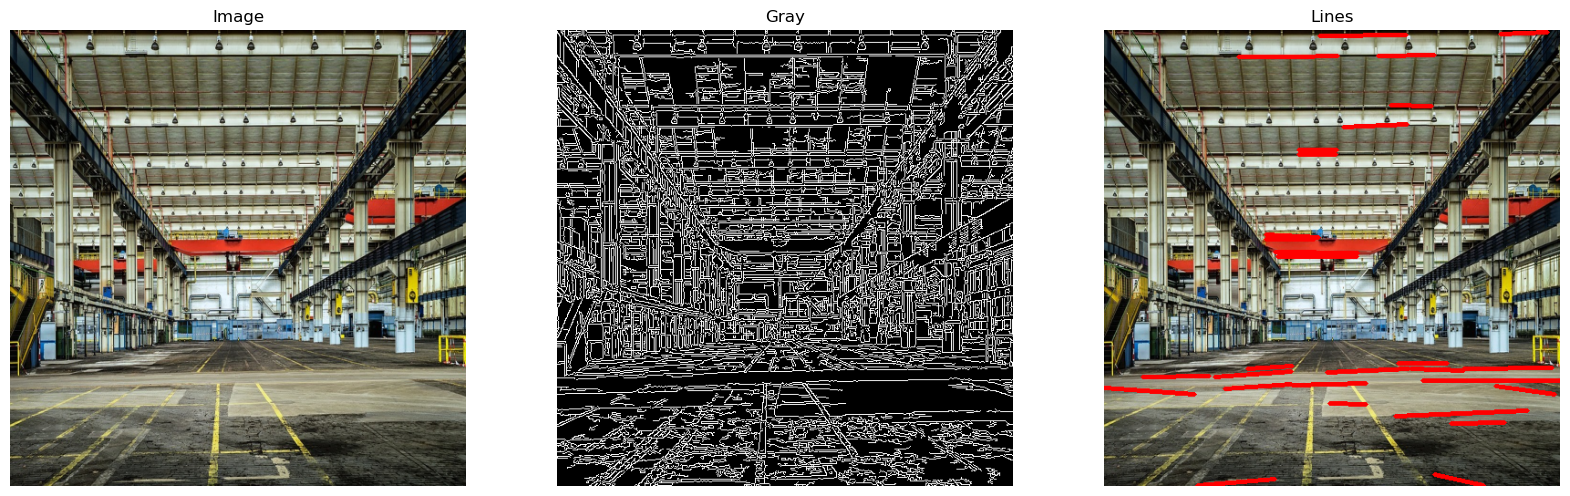

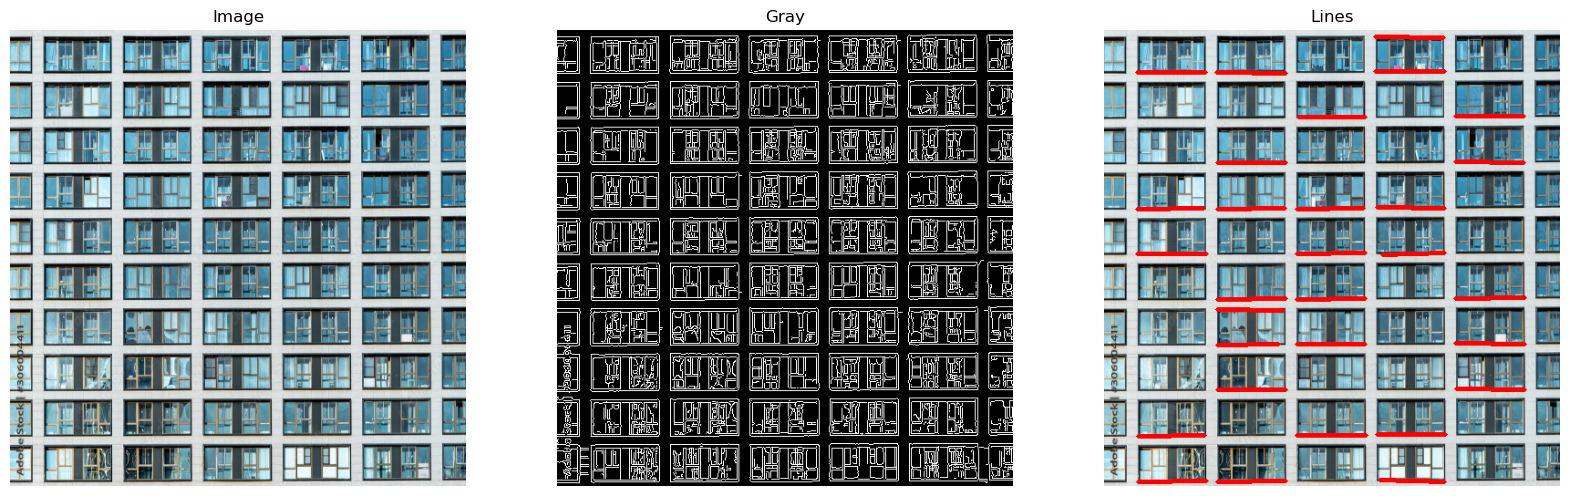

In [93]:
images_lines = [
    '05.jpg',
    '06.jpg',
    '08.jpg',
    'lines_bridge.jpg',
    'lines.jpg',
    'windows_lines_02.jpg'
]

segments = {}
for img_name in images_lines:
    fig, axs = plt.subplots(ncols=3, figsize=(20, 20))
    
    img = cv2.imread(PATH + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (500, 500), interpolation=cv2.INTER_AREA)
    axs[0].set_title('Image')
    axs[0].imshow(img)
    axs[0].axis('off')
    
    img_gray = img.copy()
    img_gray = rgb2gray(img_gray)
    img_gray = cv2.Canny(img_gray, threshold1=40, threshold2=250, apertureSize=3)
    axs[1].set_title('Gray')
    axs[1].imshow(img_gray, cmap='gray')
    axs[1].axis('off')
    
    y_white, X_white = np.where(img_gray == 255)
    y_white = img.shape[0] - y_white # cartesian - flip the axis
    
    lines = detect_lines(X_white, y_white, 30)
    segments[img_name] = lines
    
    img_lines = deepcopy(img)

    for line in lines:
        (x0, y0), (x1, y1) = line

        cv2.line(img_lines, (x0, img.shape[0] - y0),\
                            (x1, img.shape[0] - y1), (255, 0, 0), thickness=4)

    axs[2].set_title('Lines')
    axs[2].imshow(img_lines)
    axs[2].axis('off')

----

----

(-0.5, 239.5, 326.5, -0.5)

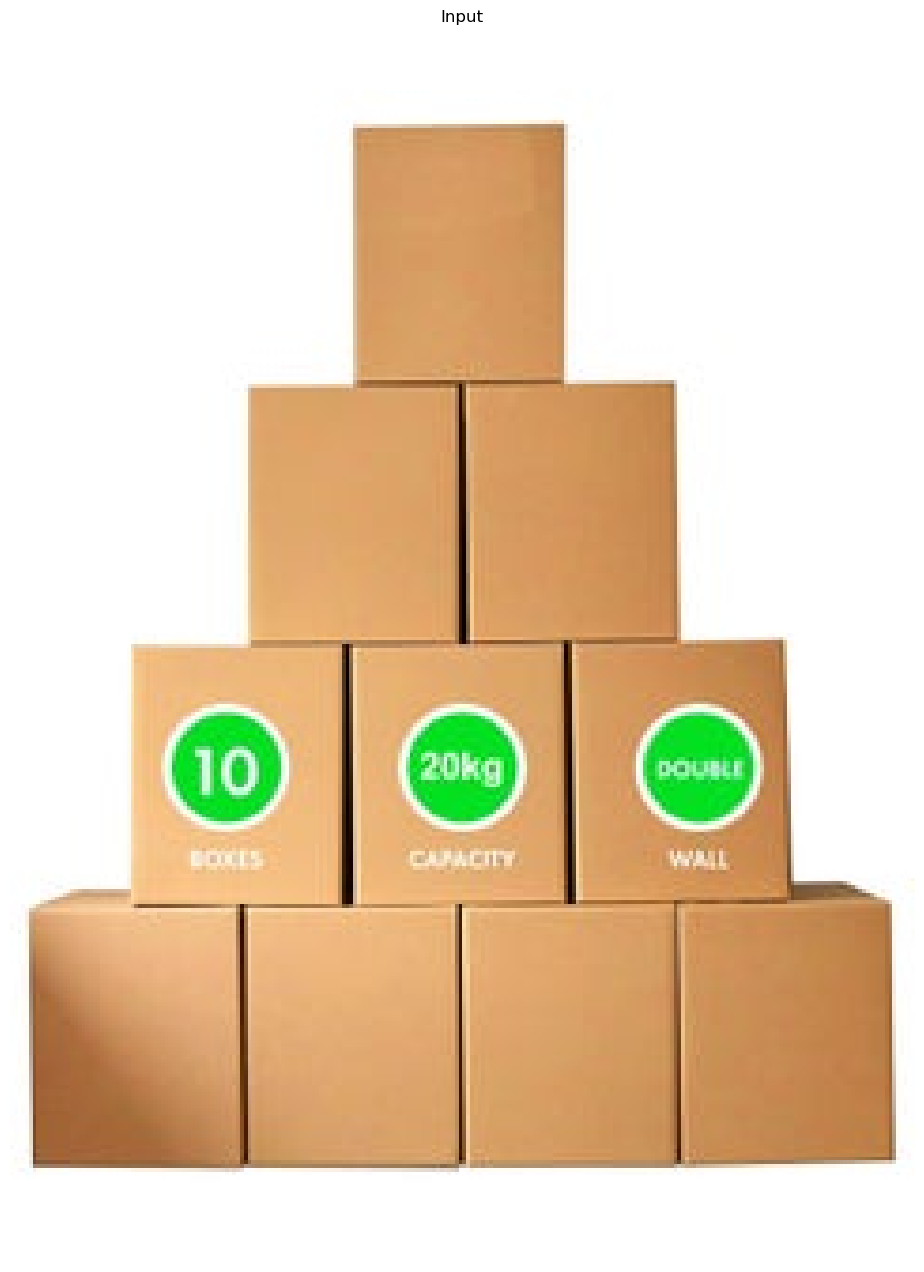

In [112]:
img_boxes = cv2.imread(PATH + "11-boxes.jpg")
img_boxes = cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB)

# img_boxes = cv2.resize(img_boxes, (400, 400), interpolation=cv2.INTER_AREA)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Input')
ax1.imshow(img_boxes)
ax1.axis('off')

In [113]:
img_boxes.shape

(327, 240, 3)

(-0.5, 239.5, 326.5, -0.5)

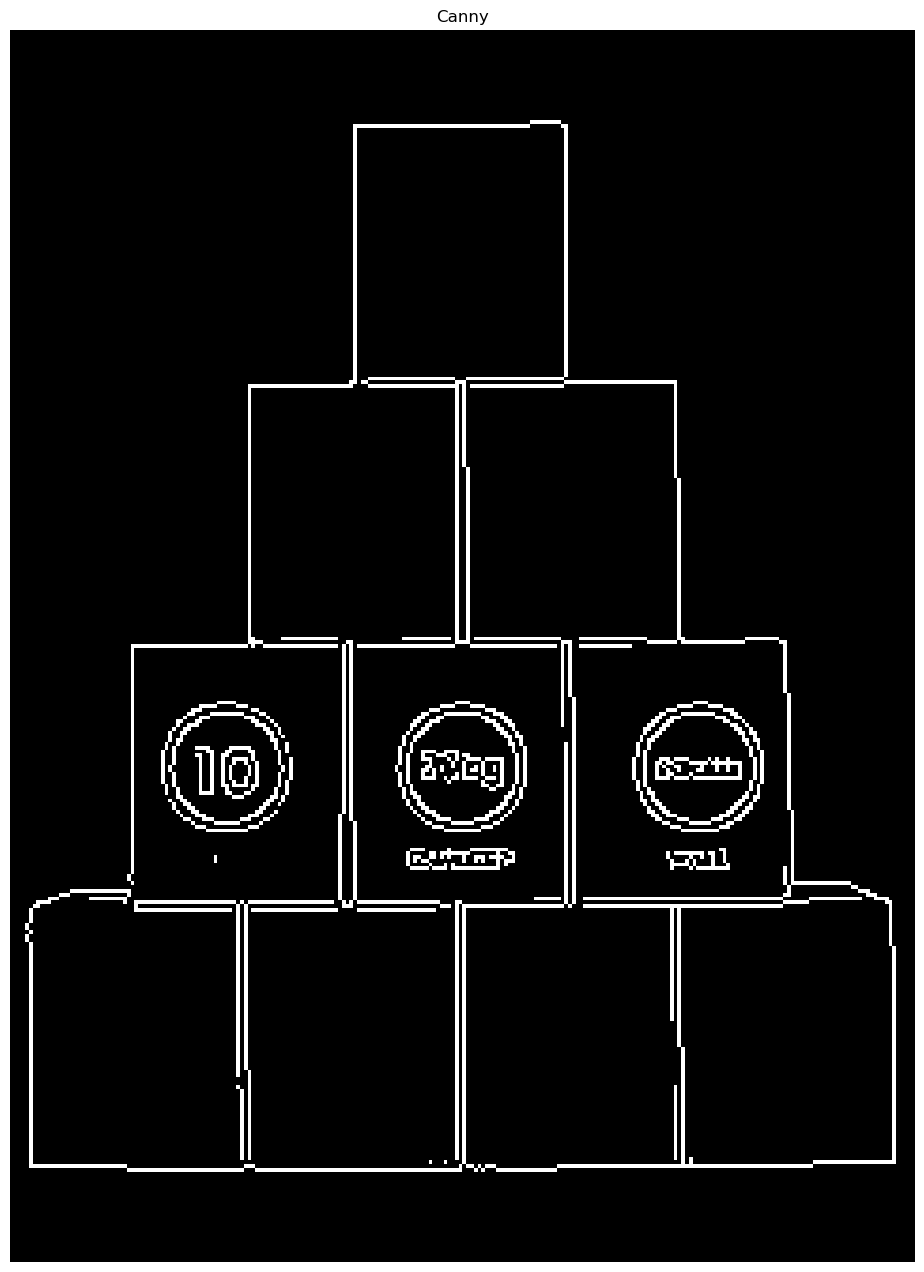

In [114]:
img_gray = img_boxes.copy()
img_gray = rgb2gray(img_gray)
img_gray = cv2.Canny(img_gray, threshold1=100, threshold2=200, apertureSize=3)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Canny')
ax1.imshow(img_gray, cmap='gray')
ax1.axis('off')

In [121]:
y_white, X_white = np.where(img_gray == 255)
y_white = img_boxes.shape[0] - y_white # cartesian - flip the axis

y_white.shape, X_white.shape

((3412,), (3412,))

In [131]:
lines = detect_lines(X_white, y_white, 50)

(-0.5, 239.5, 326.5, -0.5)

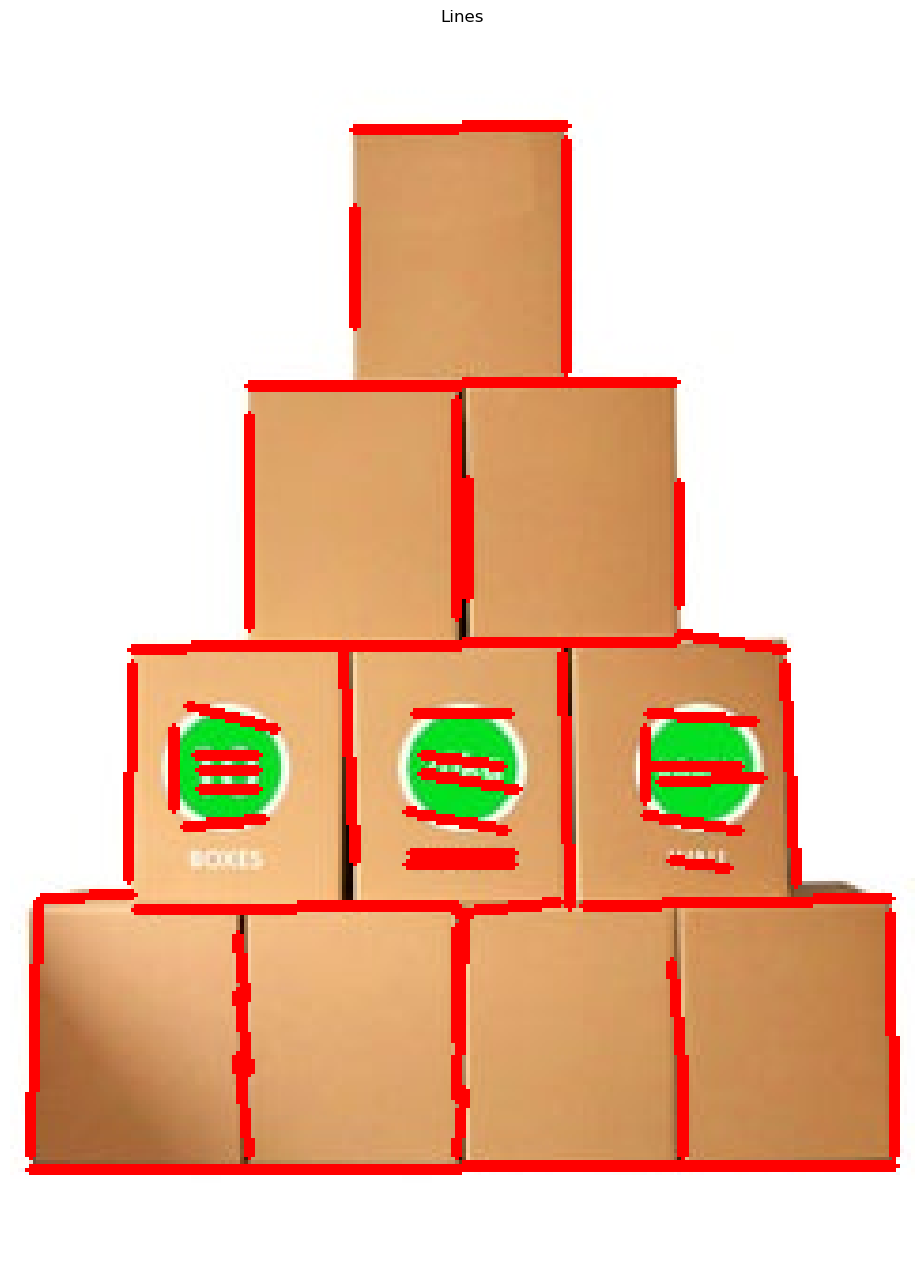

In [132]:
img_lines = deepcopy(img_boxes)
for line in lines:
    (x0, y0), (x1, y1) = line
    
    cv2.line(img_lines, (x0, img_boxes.shape[0] - y0),\
                        (x1, img_boxes.shape[0] - y1), (255, 0, 0), thickness=2)

fig, ax1 = plt.subplots(ncols=1, figsize=(16, 16))
ax1.set_title('Lines')
ax1.imshow(img_lines)
ax1.axis('off')